# Testing the ability to distinguish signal events from background

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

### Record (Raw) Wire Features 

In [3]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [4]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Prepare Neighbour Features

In [5]:
# # Sum of energy desposits of neighbours 
# sum_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T).T
# # Sum of neighbouring neighbour deposits (smoothed clustering)
# sum_neigh_deposits_2 = hits.cydet.point_neighbours.dot(sum_neigh_deposits.T).T
# sum_neigh_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# # Number of neighbours with hits
# num_neigh_deposits = hits.cydet.point_neighbours.dot(deposits.T > 0).T
# # Number of signal-like neighbours
# sig_like_neighs = hits.cydet.point_neighbours.dot(sig_like.T).T

### Left/Right Neighbour Features

In [6]:
# # Sum of energy desposits of left/right neighbours 
# sum_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T).T
# # Sum of left/right neighbouring left/right neighbour deposits
# sum_lr_deposits_2 = hits.cydet.lr_neighbours.dot(sum_neigh_deposits.T).T
# sum_lr_deposits_2 -= deposits # wires pick up their own value, subtract it back out
# # Number of neighbours with hits
# num_lr_deposits = hits.cydet.lr_neighbours.dot(deposits.T > 0).T
# # Number of signal-like neighbours
# sig_like_lr = hits.cydet.lr_neighbours.dot(sig_like.T).T
# # Sum of relative timing of left/right neighbours
# sum_lr_time = hits.cydet.lr_neighbours.dot(rel_time.T).T
# # Get difference measure of time between hit and possible neighbouring hits
# diff_lr_time_metric = numpy.vstack(hits.get_time_neighbours_metric(i) for i in range(hits.n_events))

In [7]:
#diff_lr_time_metric = numpy.log(diff_lr_time_metric)

## Train/test splitting 

In [8]:
from sklearn.cross_validation import train_test_split
train_events, test_events = train_test_split(range(len(labels)), train_size=0.15, test_size=0.25)

In [9]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id
# # Neighbour Features
# features['sum_neigh_deposits'] = sum_neigh_deposits * 100
# features['num_neigh_deposits'] = num_neigh_deposits
# features['sum_neigh_deposits_2'] = sum_neigh_deposits_2
# features['sig_like_neighs'] = sig_like_neighs
# # Left-Right neighbour features
# features['sum_lr_deposits'] = sum_lr_deposits * 100
# features['sum_lr_time'] = sum_lr_time
# features['num_lr_deposits'] = num_lr_deposits
# features['sum_lr_deposits_2'] = sum_lr_deposits_2
# features['sig_like_lr'] = sig_like_lr
# features['diff_lr_time_metric'] = diff_lr_time_metric
# Truth values
features['labels'] = labels

In [10]:
train_features = features.keys()[:-1]

In [11]:
data = numpy.dstack(features.values())

In [12]:
data.shape

(3445, 4482, 4)

In [13]:
n_feats = data.shape[-1]
train_data, test_data = data[train_events].reshape(-1, n_feats), data[test_events].reshape(-1, n_feats)

In [14]:
def train_classifier(data, features, train_events, train_wires, train_target, classifier):
    """
    data - original dataset with prepared features
    features - names of features in dataset
    train_events - ids of events 
    train_wires - which wires to use (boolean numpy.array of shape [n_events, n_wires])
    train_target - numpy.array of shape [n_events, n_wires] with zeros and ones, and whatever in 
    classifier - rep classifier to be used
    """
    train_wires = train_wires[train_events].flatten()
    train_data = data[train_events].reshape(-1, data.shape[-1])[train_wires, :]
    train_data = pandas.DataFrame(data=train_data, columns=features)
    train_target = train_target[train_events].flatten()[train_wires]
    classifier.fit(train_data, train_target)
    return classifier

def predict_classifier(data, features, classifier, apply_mask, default_value=-1):
    """
    data - original data [n_samples, n_wires, n_features]
    features - features of it
    apply_mask - numpy.array of shape [n_samples, n_wires]
    classifier - used classifier
    """
    apply_mask = apply_mask.flatten()
    test_data = pandas.DataFrame(data=data.reshape([-1, data.shape[-1]]), columns=features)
    result = numpy.zeros(len(test_data)) + default_value
    result[apply_mask] = classifier.predict_proba(test_data[apply_mask])[:, 1]
    return result.reshape(data.shape[:2])

In [15]:
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pandas
time_deposit_clf = train_classifier(data=data, features=features.keys(), train_events=train_events, 
    train_wires=features['labels'] != 0, 
    train_target=2 - features['labels'], 
    classifier=SklearnClassifier(GradientBoostingClassifier(n_estimators=10), features=train_features))

In [16]:
test_data = data[test_events]
test_pred = predict_classifier(test_data, features, time_deposit_clf, 
                               apply_mask=test_data[:, :, -1] != 0)

In [17]:
train_data = data[train_events]
train_pred = predict_classifier(train_data, features, time_deposit_clf, 
                                apply_mask=train_data[:, :, -1] != 0)

## Testing hough  

In [18]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   

In [19]:
from tracking import Hough
from scipy import sparse

In [21]:
test_triplelabels = features['labels'][test_events].flatten()
test_binary_labels = numpy.take([0, 1, 0], test_triplelabels)
test_before_hough = test_pred.flatten()
test_problematic_weights = (test_triplelabels != 0) * abs(test_binary_labels - test_before_hough) ** 2

In [22]:
from sklearn.metrics import roc_auc_score
print roc_auc_score(test_binary_labels, test_before_hough, sample_weight=(test_triplelabels != 0))
print roc_auc_score(test_binary_labels, test_before_hough, sample_weight=test_problematic_weights)

0.973044617492
0.521890897482


In [23]:
hough = Hough(hits)
wire_rhos, wire_phis = hits.cydet.get_points_rhos_and_phis()
wire_xs, wire_ys = hits.cydet.get_points_xs_and_ys()
track_rhos, track_phis = hough.track.get_points_rhos_and_phis()
track_xs, track_ys = hough.track.get_points_xs_and_ys()

In [24]:
# neighs = hough.track.point_neighbours
# neighs.shape

In [25]:
default = [[30, 33.6, 35]]
submatrices = []

even_wires = hits.cydet.point_pol != 1
odd_wires = hits.cydet.point_pol == 1

for rmin, rmean, rmax in default: #[[30, 33, 35], [26, 29, 32]]:
    hough = Hough(hits, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax)
    corresp = hough.correspondence

    corresp_odd = corresp.copy()
    corresp_odd[even_wires, :] = 0
    corresp_even = corresp.copy()
    corresp_even[odd_wires, :] = 0
    
    submatrices.append(corresp_odd)
    submatrices.append(corresp_even)

new_correspondence = sparse.hstack(submatrices)

In [26]:
new_correspondence.shape, new_correspondence.nnz

((4482, 5548), 412823)

In [27]:
corresp_orig = new_correspondence.copy()
inverse_corresp = sparse.csr_matrix(corresp_orig / (corresp_orig.sum(axis=1) + 50.))
normed_corresp = sparse.csr_matrix(corresp_orig / (corresp_orig.sum(axis=0) + 1000.))

In [28]:
def percentile_encoding(data, minimal=0.99):
    x = numpy.linspace(0, 1, 200) ** 0.5
    images = numpy.maximum(0, x - minimal) / (1 - minimal)
    percentiles = numpy.percentile(data.flatten(), 100 * x)
    return numpy.interp(data, percentiles, images)

def print_percentiles(arr, percentiles=[20, 40, 60, 80, 98, 99]):
    print numpy.percentile(arr, percentiles)
    
def is_max(data, neighs_matrix, alpha=10):
    exponents = numpy.exp(alpha * data)
    n_parts = data.shape[1] // neighs_matrix.shape[1]
    assert n_parts * neighs_matrix.shape[1] == data.shape[1]
    full_neigh = sparse.block_diag([neighs_matrix] * n_parts, format='csr')
#     full_neigh = sparse.hstack([neighs_matrix] * n_parts)

    return exponents / full_neigh.dot(exponents.T).T

In [29]:
nns = hough.track.point_neighbours 
nns = nns + sparse.identity(nns.shape[1])
nns = nns.dot(hough.track.lr_neighbours) + hough.track.lr_neighbours 
nns = sparse.csr_matrix(nns / nns.sum(axis=1))

In [30]:
class HoughTransform(object):
    def __init__(self, hough_matrix, track_neighs_matrix, min_percentile=0.97, alpha=5.):
        self.hough_matrix = hough_matrix
        self.min_percentile = min_percentile
        self.alpha = alpha
        self.normed_corresp = sparse.csr_matrix(hough_matrix / (hough_matrix.sum(axis=1) + 50.))
        self.track_neighs_matrix = track_neighs_matrix
        
    def fit(self, X):
        self.n_features = X.shape[1]
        
        original = numpy.maximum(X, 0)
        self.original_mean = original.mean()
        original -= self.original_mean

        hough_images = self.normed_corresp.T.dot(original.T).T
        
        x = numpy.linspace(0, 1, 200) ** 0.5
        self.percentiles = numpy.percentile(hough_images.flatten(), x)
        self.values_at_percentiles = numpy.maximum(0., x - self.min_percentile) / (1. - self.min_percentile)

        return self
    
    def transform(self, X):
        original = numpy.maximum(X, 0)
        original -= self.original_mean

        hough_images = self.normed_corresp.T.dot(original.T).T
        
        hough_images = numpy.interp(hough_images, self.percentiles, self.values_at_percentiles)        
        hough_images = hough_images * is_max(hough_images, neighs_matrix=self.track_neighs_matrix, alpha=5)
        hough_images = numpy.exp(self.alpha * hough_images)
        # TODO compute mean in fitting
        hough_images -= numpy.mean(hough_images)

        print_percentiles(hough_images)
        after_hough = self.normed_corresp.dot(hough_images.T).T
        
        return after_hough

    

In [31]:
# to visualize correspondence
# setup_plot_for_detector()
# sizes = numpy.array(normed_corresp[:, 1000].todense()).flatten()
# scatter(wire_phis, wire_rhos, s=sizes * 1000, )

[-0.02160575 -0.02160575 -0.02160575 -0.02160575  0.38029345  0.92800004]


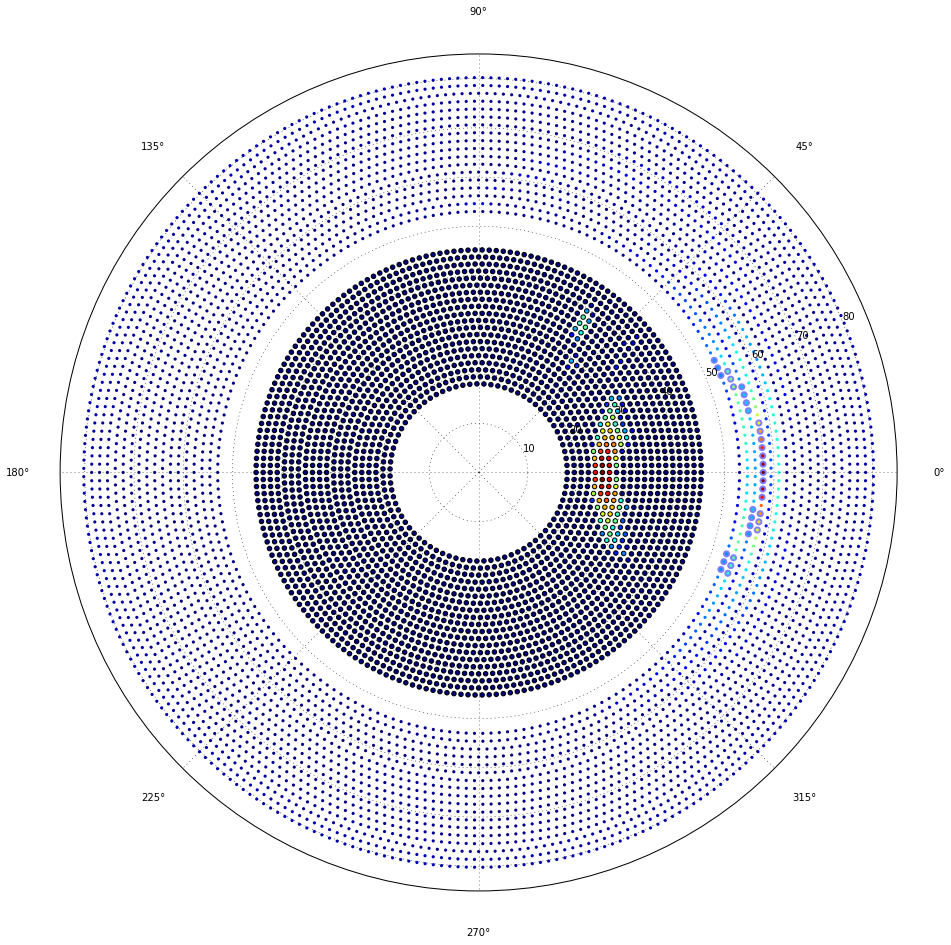

[-0.02165953 -0.02165953 -0.02165953 -0.02165953  0.37109623  0.92007628]


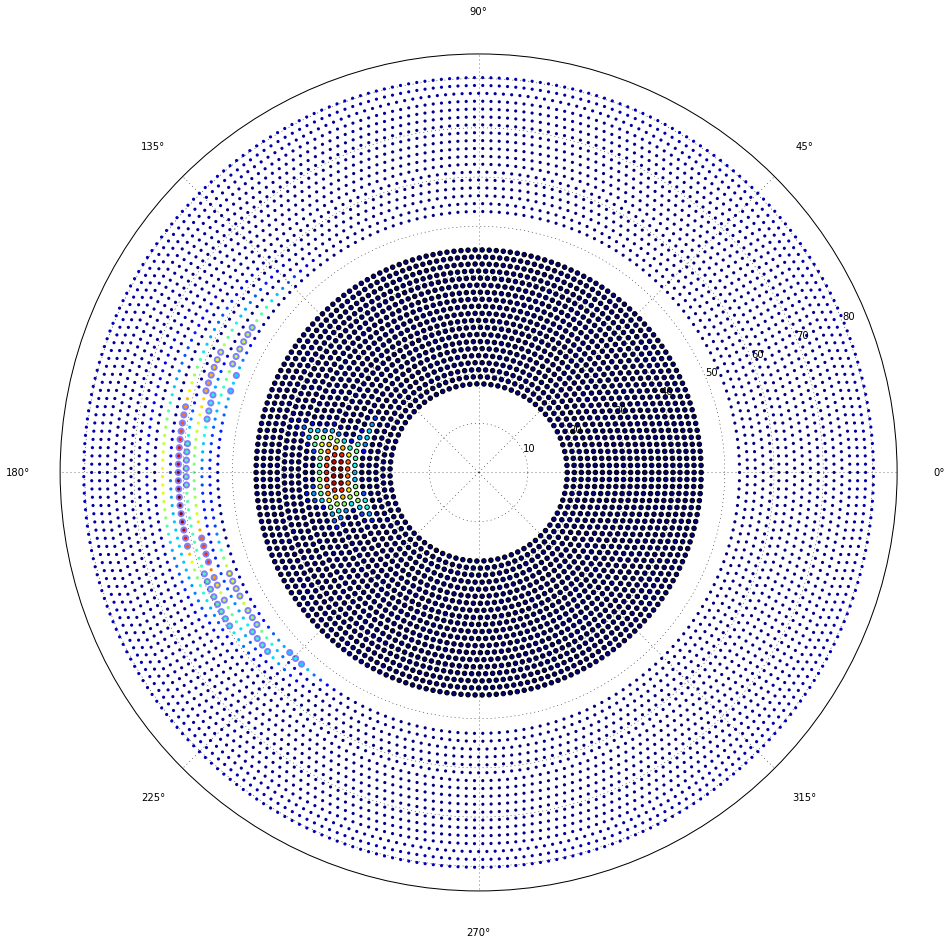

[-0.02178794 -0.02178794 -0.02178794 -0.02178794  0.36320147  0.92208543]


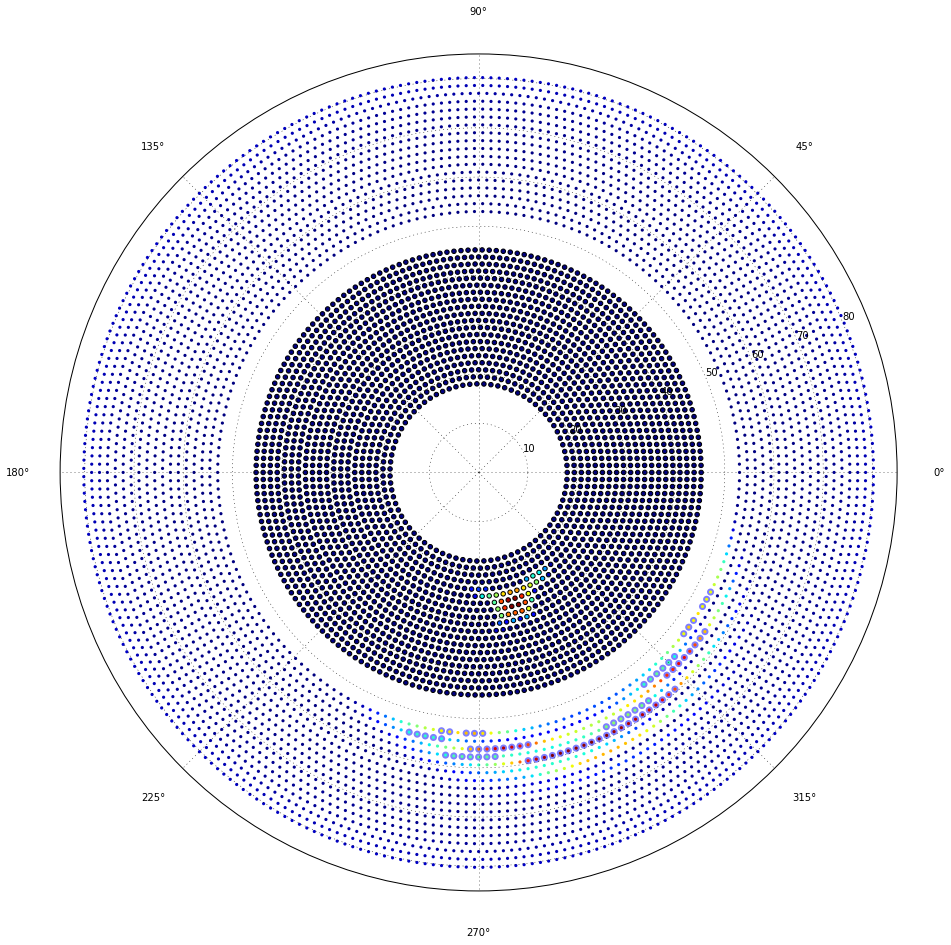

[-0.02152664 -0.02152664 -0.02152664 -0.02152664  0.36480683  0.92336569]


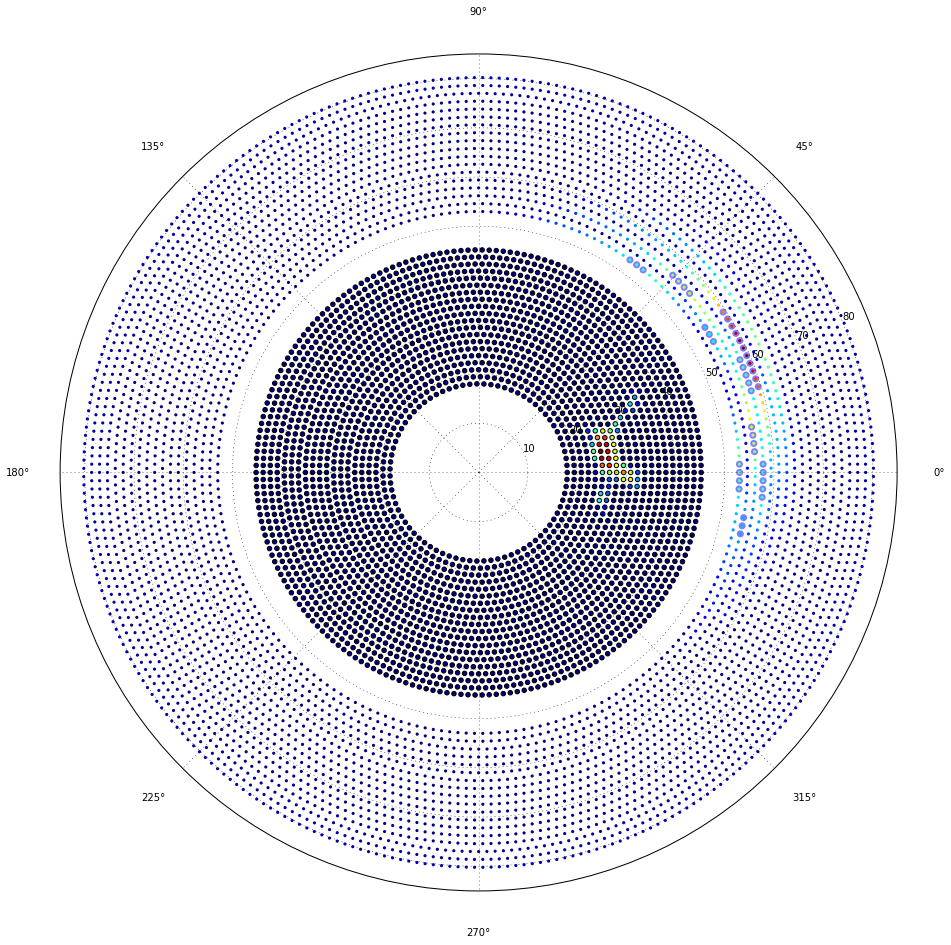

[-0.02151933 -0.02151933 -0.02151933 -0.02151933  0.37156     0.92214069]


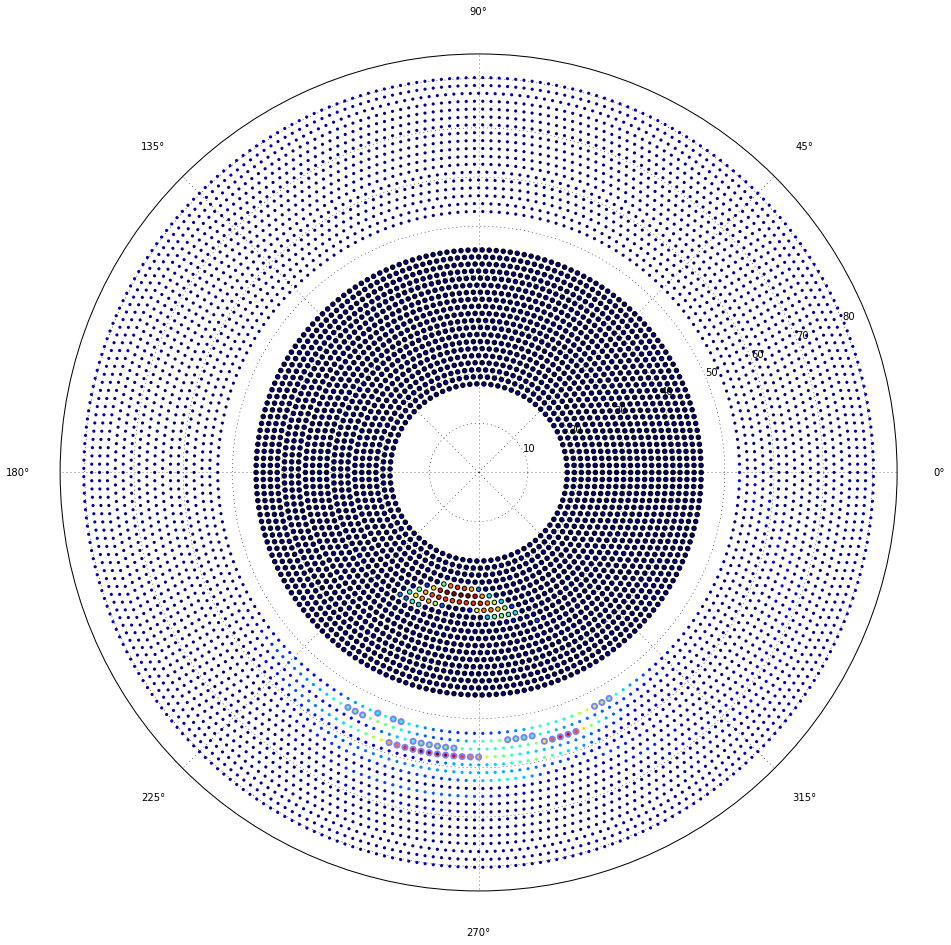

In [32]:
for event_id in [1, 2, 3, 4, 5]:
    origin = (numpy.maximum(test_pred[event_id], 0)) * 100
    origin -= origin.mean()
    colors = numpy.take(['w', 'b', 'w'], test_data[event_id, :, -1].astype('int64').flatten()) 

    setup_plot_for_detector()
    scatter(wire_phis, wire_rhos, c=colors, alpha=0.5, s=50, linewidths=0)
#     scatter(wire_phis, wire_rhos, s=origin, alpha=0.5)
    hough_image = normed_corresp.T.dot(origin.T)
    hough_image = percentile_encoding(hough_image, 0.97)
    hough_image *= is_max(hough_image[numpy.newaxis, :], nns, alpha=0).flatten()
    hough_image = numpy.exp(hough_image)
    hough_image -= hough_image.mean()
    print_percentiles(hough_image)
#     scatter(track_phis, track_rhos, c=is_max(hough_image[:len(track_phis)]))
    scatter(track_phis, track_rhos, c=hough_image[:len(track_phis)])
    scatter(wire_phis, wire_rhos, c=inverse_corresp.dot(hough_image), s=10, linewidths=0)
    show()
    

In [33]:
hough_transformer = HoughTransform(hough_matrix=new_correspondence, track_neighs_matrix=nns)
hough_transformer.fit(train_pred)
hough_transformer.transform(test_pred).shape

[ -1.86500930e+14  -1.86500930e+14  -1.86500930e+14  -1.86500930e+14
  -1.86500930e+14  -1.86500930e+14]


(862, 4482)

In [34]:
for minimal in [0.96, 0.97, 0.98]:
    for alpha in [3, 5, 10]:
        print "-----", minimal, alpha
        original = numpy.maximum(test_pred, 0)
        original -= original.mean()

        hough_images = normed_corresp.T.dot(original.T).T
        hough_images = percentile_encoding(hough_images, minimal=minimal)
        hough_images = hough_images * is_max(hough_images, neighs_matrix=nns, alpha=5)
        hough_images = numpy.exp(alpha * hough_images)
        hough_images -= numpy.mean(hough_images)

        print_percentiles(hough_images)
        after_hough = normed_corresp.dot(hough_images.T).T

        print roc_auc_score(test_binary_labels, after_hough.flatten(), sample_weight=test_problematic_weights)

----- 0.96 3
[ -0.37046088  -0.37046088  -0.37046088  -0.37046088   2.98755031
  12.79416227]
0.97622165018
----- 0.96 5
[ -3.49048545  -3.49048545  -3.49048545  -3.49048545   7.13685982
  78.43252131]
0.977942173993
----- 0.96 10
[-2625.56721073 -2625.56721073 -2625.56721073 -2625.56721073 -2491.37205279
  4249.65783941]
0.961643676745
----- 0.97 3
[-0.29190795 -0.29190795 -0.29190795 -0.29190795  0.79365796  7.79733585]
0.98146227796
----- 0.97 5
[ -3.01333502  -3.01333502  -3.01333502  -3.01333502  -0.60894061
  35.57308738]
0.981849991567
----- 0.97 10
[-2779.59516235 -2779.59516235 -2779.59516235 -2779.59516235 -2769.00526106
 -1213.51032323]
0.968371282142
----- 0.98 3
[-0.22352931 -0.22352931 -0.22352931 -0.22352931 -0.21333521  2.57050122]
0.982427360981
----- 0.98 5
[-2.85961556 -2.85961556 -2.85961556 -2.85961556 -2.84256773  5.36966899]
0.978043885539
----- 0.98 10
[-6577.6320871  -6577.6320871  -6577.6320871  -6577.6320871  -6577.59770081
 -6493.45239386]
0.95642336711
